In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import copy
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import os
from scipy.stats import norm, skew

import seaborn as sns
color = sns.color_palette()

print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
data = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub_df = pd.read_csv('../input/sample_submission.csv')

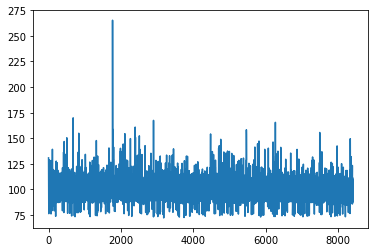

In [3]:
plt.plot(data['ID'],data['y'])

In [4]:
data = data[data.y < 250]

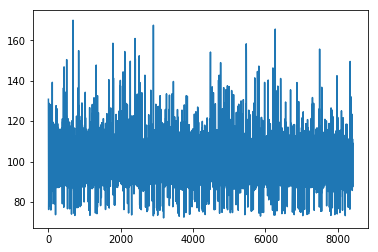

In [5]:
plt.plot(data['ID'],data['y'])


 mu = 100.63 and sigma = 12.42



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'target distribution')

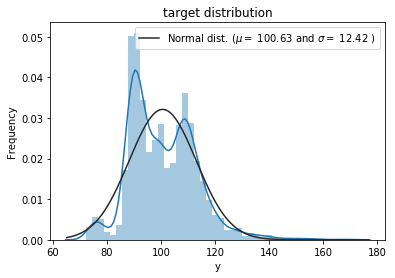

In [6]:
sns.distplot(data['y'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['y'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')

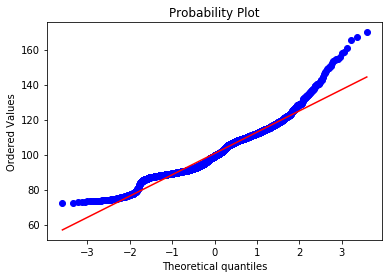

In [7]:
from scipy import stats

fig = plt.figure()
res = stats.probplot(data['y'], plot=plt)
plt.show()


 mu = 4.61 and sigma = 0.12



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'target distribution')

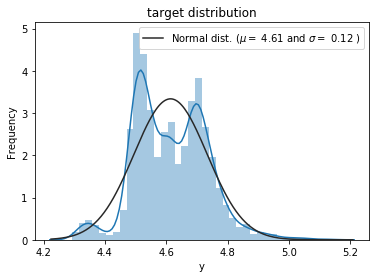

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data["y"] = np.log1p(data["y"])

#Check the new distribution 
sns.distplot(data['y'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['y'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')

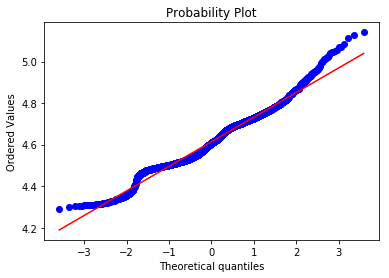

In [9]:
from scipy import stats

fig = plt.figure()
res = stats.probplot(data['y'], plot=plt)
plt.show()

In [10]:
train_objs_num = len(data)
dataset = pd.concat(objs=[data, test], axis=0)
dataset = pd.get_dummies(dataset)
data = copy.copy(dataset[:train_objs_num])
test = copy.copy(dataset[train_objs_num:])

In [11]:
useless_var = data.mean()[data.mean() == 0].index
y_train = data.y
data.drop('y', axis = 1, inplace=True)
data.drop('ID', axis = 1, inplace= True)
data.drop(useless_var.values, axis = 1, inplace=True)

test.drop('y', axis = 1, inplace=True)
test.drop('ID', axis = 1, inplace= True)
test.drop(useless_var.values, axis = 1, inplace=True)

In [12]:
depth1= ['X314', 'X315', 'X118', 'X232', 'X136', 'X127', 'X189', 'X261', 'X47', 'X236', 'X5_n', 'X5_w', 'X383', 'X204', 'X339', 'X275', 'X152', 'X50', 'X1_f', 'X6_e', 'X5_r', 'X104', 'X5_aa', 'X240', 'X206', 'X241', 'X95', 'X1_l', 'X113', 'X5_ag', 'X8_s', 'X5_v', 'X100', 'X13', 'X8_k', 'X6_c', 'X223', 'X114', 'X19', 'X115', 'X1_u', 'X80', 'X4_c', 'X68', 'X168', 'X306', 'X61', 'X350', 'X300', 'X132', 'X342', 'X1_c', 'X6_l', 'X267', 'X379', 'X23', 'X316', 'X8_j', 'X6_g', 'X5_m', 'X12', 'X0_z', 'X0_x', 'X77', 'X354', 'X196', 'X8_a', 'X283', 'X51', 'X8_g', 'X225', 'X292', 'X2_r', 'X148', 'X8_d', 'X8_x', 'X203', 'X5_k', 'X8_o', 'X101', 'X220', 'X191', 'X5_ab', 'X8_i', 'X8_w', 'X56', 'X65', 'X0_ab', 'X131', 'X224', 'X155', 'X181', 'X351', 'X0_au', 'X64', 'X75', 'X5_af', 'X105', 'X6_j', 'X117', 'X151', 'X177', 'X0_l', 'X362', 'X3_g', 'X5_l', 'X8_v', 'X285', 'X378', 'X244', 'X343', 'X228', 'X5_ae', 'X5_p', 'X273', 'X380', 'X5_ah', 'X27', 'X1_t', 'X6_h', 'X345', 'X1_h', 'X176', 'X116', 'X171', 'X1_aa', 'X6_d', 'X201', 'X122', 'X3_a', 'X5_ad', 'X178', 'X143', 'X38', 'X142', 'X14', 'X361', 'X1_q']
depth2= [('X118', 'X314'), ('X314', 'X315'), ('X232', 'X314'), ('X136', 'X315'), ('X127', 'X232'), ('X189', 'X315'), ('X232', 'X315'), ('X314', 'X47'), ('X261', 'X47'), ('X315', 'X47'), ('X232', 'X261'), ('X113', 'X118'), ('X118', 'X261'), ('X261', 'X5_r'), ('X236', 'X47'), ('X314', 'X61'), ('X232', 'X5_k'), ('X115', 'X261'), ('X206', 'X50'), ('X236', 'X261'), ('X5_w', 'X8_k'), ('X383', 'X50'), ('X315', 'X6_c'), ('X232', 'X47'), ('X241', 'X5_n'), ('X47', 'X5_w'), ('X236', 'X275'), ('X1_l', 'X5_aa'), ('X127', 'X136'), ('X261', 'X61'), ('X152', 'X5_n'), ('X143', 'X315'), ('X118', 'X5_w'), ('X118', 'X5_r'), ('X5_aa', 'X5_w'), ('X104', 'X118'), ('X152', 'X383'), ('X275', 'X5_n'), ('X118', 'X236'), ('X383', 'X5_n'), ('X351', 'X47'), ('X5_aa', 'X80'), ('X113', 'X261'), ('X240', 'X6_l'), ('X236', 'X314'), ('X13', 'X1_l'), ('X316', 'X6_e'), ('X115', 'X1_f'), ('X275', 'X339'), ('X114', 'X1_c'), ('X136', 'X232'), ('X127', 'X6_e'), ('X339', 'X47'), ('X47', 'X61'), ('X115', 'X314'), ('X168', 'X8_k'), ('X1_u', 'X47'), ('X151', 'X236'), ('X127', 'X47'), ('X152', 'X19'), ('X223', 'X6_g'), ('X118', 'X1_aa'), ('X104', 'X68'), ('X101', 'X152'), ('X306', 'X5_w'), ('X23', 'X8_k'), ('X113', 'X314'), ('X5_r', 'X5_w'), ('X47', 'X5_n'), ('X383', 'X6_l'), ('X127', 'X5_n'), ('X204', 'X5_n'), ('X6_l', 'X8_j'), ('X0_x', 'X47'), ('X300', 'X383'), ('X240', 'X8_s'), ('X5_n', 'X5_w'), ('X1_c', 'X5_r'), ('X100', 'X342'), ('X196', 'X5_n'), ('X47', 'X5_aa'), ('X0_z', 'X152'), ('X47', 'X5_ad'), ('X204', 'X383'), ('X379', 'X5_m'), ('X105', 'X232'), ('X19', 'X5_n'), ('X118', 'X1_q'), ('X261', 'X339'), ('X191', 'X339'), ('X350', 'X47'), ('X236', 'X240'), ('X5_r', 'X8_v'), ('X148', 'X95'), ('X127', 'X339'), ('X350', 'X5_n'), ('X132', 'X283'), ('X77', 'X8_j'), ('X1_l', 'X56'), ('X0_x', 'X1_u'), ('X12', 'X5_ag'), ('X1_f', 'X8_d'), ('X204', 'X236'), ('X204', 'X316'), ('X116', 'X47'), ('X113', 'X8_a'), ('X6_l', 'X77'), ('X204', 'X95'), ('X225', 'X383'), ('X100', 'X5_ab'), ('X100', 'X1_f'), ('X5_m', 'X8_s'), ('X19', 'X6_g'), ('X115', 'X8_s'), ('X339', 'X383'), ('X127', 'X1_f'), ('X118', 'X316'), ('X204', 'X5_aa'), ('X118', 'X8_a'), ('X115', 'X155'), ('X1_f', 'X5_v'), ('X104', 'X275'), ('X132', 'X1_l'), ('X1_f', 'X3_g'), ('X1_c', 'X315'), ('X23', 'X5_w'), ('X132', 'X339'), ('X116', 'X77'), ('X12', 'X383'), ('X2_r', 'X8_a'), ('X131', 'X5_aa'), ('X51', 'X5_k'), ('X5_ah', 'X8_g'), ('X204', 'X4_c'), ('X383', 'X5_v'), ('X362', 'X5_n'), ('X220', 'X342'), ('X204', 'X339'), ('X132', 'X354'), ('X132', 'X203'), ('X204', 'X240'), ('X383', 'X5_l'), ('X236', 'X292'), ('X1_c', 'X343'), ('X267', 'X95'), ('X292', 'X378'), ('X350', 'X5_l'), ('X345', 'X61'), ('X240', 'X8_o'), ('X117', 'X275'), ('X306', 'X5_n'), ('X100', 'X8_o'), ('X0_x', 'X224'), ('X5_n', 'X6_j'), ('X178', 'X61'), ('X236', 'X383'), ('X19', 'X5_m'), ('X236', 'X95'), ('X132', 'X5_v'), ('X132', 'X6_g'), ('X132', 'X236'), ('X19', 'X204'), ('X5_ag', 'X5_k'), ('X315', 'X6_g'), ('X240', 'X8_x'), ('X267', 'X316'), ('X383', 'X75'), ('X261', 'X383'), ('X105', 'X5_ag'), ('X267', 'X383'), ('X5_v', 'X5_w'), ('X65', 'X6_j'), ('X177', 'X267'), ('X342', 'X95'), ('X354', 'X6_j'), ('X306', 'X75'), ('X12', 'X95'), ('X115', 'X64'), ('X105', 'X114'), ('X181', 'X316'), ('X350', 'X380'), ('X383', 'X5_r'), ('X383', 'X8_x'), ('X292', 'X5_n'), ('X113', 'X3_a'), ('X142', 'X68'), ('X0_x', 'X351'), ('X292', 'X339'), ('X342', 'X5_m'), ('X1_l', 'X8_w'), ('X204', 'X47'), ('X151', 'X6_g'), ('X6_h', 'X75'), ('X240', 'X342'), ('X1_h', 'X64'), ('X12', 'X5_v'), ('X267', 'X51'), ('X342', 'X5_ag'), ('X176', 'X8_s'), ('X339', 'X4_c'), ('X171', 'X64'), ('X339', 'X8_d'), ('X206', 'X383'), ('X285', 'X350'), ('X342', 'X5_v'), ('X14', 'X68'), ('X1_u', 'X203'), ('X148', 'X244'), ('X203', 'X4_c'), ('X228', 'X8_w'), ('X342', 'X5_aa'), ('X12', 'X5_r'), ('X0_au', 'X339'), ('X132', 'X8_i'), ('X203', 'X267'), ('X0_au', 'X0_z'), ('X100', 'X23'), ('X350', 'X8_v'), ('X292', 'X8_d'), ('X177', 'X1_u'), ('X4_c', 'X5_w'), ('X148', 'X267'), ('X104', 'X95'), ('X339', 'X95'), ('X1_t', 'X5_ae'), ('X206', 'X8_i'), ('X228', 'X5_aa'), ('X315', 'X351'), ('X104', 'X342'), ('X5_p', 'X8_a'), ('X0_l', 'X4_c'), ('X104', 'X206'), ('X5_v', 'X8_d'), ('X5_m', 'X95'), ('X316', 'X5_ah'), ('X104', 'X5_w'), ('X1_t', 'X8_a'), ('X292', 'X5_ag'), ('X292', 'X5_af'), ('X1_u', 'X6_d'), ('X306', 'X4_c'), ('X0_ab', 'X4_c'), ('X5_aa', 'X5_ah'), ('X240', 'X275'), ('X240', 'X95'), ('X342', 'X5_af'), ('X273', 'X5_ae'), ('X0_au', 'X5_r'), ('X115', 'X177'), ('X0_ab', 'X204')]
depth3=[('X136', 'X314', 'X315'), ('X127', 'X232', 'X314'), ('X189', 'X314', 'X315'), ('X232', 'X314', 'X315'), ('X113', 'X118', 'X314'), ('X314', 'X315', 'X47'), ('X143', 'X314', 'X315'), ('X232', 'X314', 'X47'), ('X314', 'X315', 'X6_c'), ('X118', 'X1_q', 'X314'), ('X118', 'X261', 'X5_r'), ('X236', 'X314', 'X47'), ('X118', 'X1_aa', 'X314'), ('X261', 'X315', 'X47'), ('X232', 'X261', 'X5_k'), ('X118', 'X314', 'X5_r'), ('X118', 'X314', 'X8_a'), ('X118', 'X1_aa', 'X261'), ('X261', 'X5_r', 'X8_v'), ('X127', 'X232', 'X261'), ('X314', 'X47', 'X61'), ('X236', 'X261', 'X275'), ('X206', 'X383', 'X50'), ('X178', 'X314', 'X61'), ('X127', 'X136', 'X232'), ('X115', 'X1_f', 'X261'), ('X236', 'X261', 'X47'), ('X115', 'X261', 'X8_s'), ('X104', 'X118', 'X5_w'), ('X136', 'X232', 'X261'), ('X118', 'X236', 'X5_w'), ('X168', 'X5_w', 'X8_k'), ('X261', 'X47', 'X5_ad'), ('X23', 'X5_w', 'X8_k'), ('X275', 'X383', 'X5_n'), ('X261', 'X47', 'X5_w'), ('X261', 'X47', 'X61'), ('X152', 'X19', 'X5_n'), ('X261', 'X345', 'X61'), ('X261', 'X5_r', 'X5_w'), ('X127', 'X232', 'X47'), ('X261', 'X350', 'X47'), ('X113', 'X314', 'X47'), ('X13', 'X1_l', 'X5_aa'), ('X127', 'X232', 'X6_e'), ('X0_x', 'X1_u', 'X47'), ('X113', 'X261', 'X8_a'), ('X0_x', 'X351', 'X47'), ('X232', 'X51', 'X5_k'), ('X306', 'X47', 'X5_w'), ('X315', 'X351', 'X47'), ('X241', 'X47', 'X5_n'), ('X204', 'X316', 'X6_e'), ('X115', 'X1_f', 'X314'), ('X232', 'X5_ag', 'X5_k'), ('X240', 'X383', 'X6_l'), ('X114', 'X1_c', 'X5_r'), ('X127', 'X232', 'X5_n'), ('X113', 'X261', 'X3_a'), ('X115', 'X155', 'X314'), ('X241', 'X275', 'X5_n'), ('X383', 'X6_l', 'X8_j'), ('X101', 'X152', 'X383'), ('X47', 'X5_n', 'X5_w'), ('X19', 'X223', 'X6_g'), ('X47', 'X5_w', 'X8_k'), ('X196', 'X275', 'X5_n'), ('X47', 'X5_aa', 'X80'), ('X191', 'X275', 'X339'), ('X0_x', 'X224', 'X47'), ('X1_l', 'X47', 'X5_aa'), ('X261', 'X339', 'X47'), ('X236', 'X240', 'X275'), ('X5_aa', 'X5_w', 'X80'), ('X300', 'X383', 'X5_l'), ('X0_z', 'X152', 'X19'), ('X127', 'X232', 'X339'), ('X148', 'X267', 'X95'), ('X1_l', 'X5_aa', 'X5_w'), ('X152', 'X204', 'X383'), ('X204', 'X350', 'X5_n'), ('X1_l', 'X56', 'X5_aa'), ('X105', 'X232', 'X5_ag'), ('X204', 'X236', 'X47'), ('X105', 'X114', 'X232'), ('X132', 'X283', 'X339'), ('X19', 'X204', 'X5_n'), ('X151', 'X236', 'X275'), ('X339', 'X383', 'X47'), ('X127', 'X1_f', 'X232'), ('X204', 'X5_aa', 'X5_w'), ('X100', 'X342', 'X5_ab'), ('X100', 'X1_f', 'X5_v'), ('X6_l', 'X77', 'X8_j'), ('X131', 'X204', 'X5_aa'), ('X12', 'X5_ag', 'X5_r'), ('X225', 'X383', 'X5_r'), ('X118', 'X204', 'X316'), ('X204', 'X383', 'X5_v'), ('X104', 'X275', 'X339'), ('X116', 'X351', 'X47'), ('X1_f', 'X236', 'X8_d'), ('X132', 'X1_l', 'X5_v'), ('X1_f', 'X3_g', 'X5_v'), ('X132', 'X339', 'X354'), ('X152', 'X19', 'X204'), ('X204', 'X383', 'X50'), ('X12', 'X383', 'X5_l'), ('X204', 'X339', 'X5_n'), ('X1_c', 'X315', 'X5_r'), ('X5_aa', 'X5_r', 'X5_w'), ('X151', 'X236', 'X47'), ('X116', 'X13', 'X47'), ('X117', 'X275', 'X339'), ('X116', 'X6_l', 'X77'), ('X306', 'X362', 'X5_n'), ('X1_t', 'X2_r', 'X8_a'), ('X236', 'X383', 'X95'), ('X100', 'X342', 'X8_o'), ('X220', 'X342', 'X5_aa'), ('X19', 'X204', 'X5_m'), ('X5_aa', 'X5_ah', 'X8_g'), ('X132', 'X236', 'X5_v'), ('X1_u', 'X47', 'X95'), ('X100', 'X240', 'X342'), ('X1_c', 'X343', 'X5_r'), ('X5_aa', 'X5_w', 'X8_k'), ('X379', 'X5_m', 'X95'), ('X267', 'X316', 'X383'), ('X240', 'X6_l', 'X8_o'), ('X306', 'X5_n', 'X6_j'), ('X12', 'X342', 'X95'), ('X350', 'X380', 'X5_l'), ('X5_aa', 'X5_v', 'X5_w'), ('X261', 'X383', 'X5_r'), ('X204', 'X383', 'X8_x'), ('X19', 'X315', 'X6_g'), ('X306', 'X383', 'X75'), ('X292', 'X339', 'X5_n'), ('X240', 'X6_l', 'X8_x'), ('X1_l', 'X5_aa', 'X8_w'), ('X267', 'X383', 'X51'), ('X240', 'X342', 'X5_m'), ('X1_h', 'X241', 'X5_n'), ('X0_l', 'X379', 'X5_m'), ('X204', 'X47', 'X95'), ('X177', 'X1_u', 'X267'), ('X132', 'X203', 'X6_g'), ('X23', 'X5_aa', 'X5_w'), ('X181', 'X204', 'X316'), ('X176', 'X240', 'X8_s'), ('X104', 'X142', 'X68'), ('X306', 'X6_h', 'X75'), ('X339', 'X4_c', 'X8_d'), ('X0_ab', 'X65', 'X6_j'), ('X0_ab', 'X354', 'X6_j'), ('X115', 'X1_h', 'X64'), ('X204', 'X240', 'X95'), ('X5_m', 'X8_s', 'X95'), ('X12', 'X5_r', 'X5_v'), ('X104', 'X5_w', 'X68'), ('X132', 'X203', 'X4_c'), ('X151', 'X19', 'X6_g'), ('X292', 'X339', 'X378'), ('X342', 'X5_aa', 'X5_v'), ('X148', 'X244', 'X95'), ('X115', 'X177', 'X267'), ('X203', 'X267', 'X4_c'), ('X151', 'X236', 'X383'), ('X0_au', 'X0_z', 'X339'), ('X104', 'X206', 'X383'), ('X240', 'X8_s', 'X95'), ('X285', 'X350', 'X5_l'), ('X1_u', 'X203', 'X47'), ('X104', 'X14', 'X68'), ('X342', 'X4_c', 'X5_ag'), ('X171', 'X1_h', 'X64'), ('X204', 'X4_c', 'X5_w'), ('X228', 'X5_aa', 'X8_w'), ('X100', 'X23', 'X5_w'), ('X236', 'X292', 'X8_d'), ('X104', 'X339', 'X95'), ('X204', 'X240', 'X8_s'), ('X132', 'X203', 'X8_i'), ('X0_l', 'X5_m', 'X8_s'), ('X0_l', 'X204', 'X4_c'), ('X350', 'X5_l', 'X8_v'), ('X104', 'X206', 'X8_i'), ('X104', 'X342', 'X5_w'), ('X1_t', 'X5_p', 'X8_a'), ('X0_au', 'X273', 'X339'), ('X236', 'X292', 'X5_ag'), ('X316', 'X5_aa', 'X5_ah'), ('X1_u', 'X47', 'X6_d'), ('X0_ab', 'X306', 'X4_c'), ('X236', 'X5_v', 'X8_d'), ('X236', 'X292', 'X5_af'), ('X240', 'X275', 'X95'), ('X1_t', 'X273', 'X5_ae'), ('X0_au', 'X4_c', 'X5_r'), ('X0_ab', 'X204', 'X5_ag'), ('X342', 'X4_c', 'X5_af'), ('X122', 'X1_t', 'X5_ae'), ('X19', 'X1_h', 'X5_n'), ('X236', 'X292', 'X378'), ('X204', 'X240', 'X261'), ('X114', 'X228', 'X5_aa'), ('X177', 'X203', 'X27'), ('X0_au', 'X201', 'X4_c'), ('X203', 'X27', 'X8_g'), ('X0_l', 'X131', 'X38'), ('X0_l', 'X131', 'X361')]

In [13]:
data = data[depth1]
test = test[depth1]
for (a,b) in depth2[0:16]:
    data.loc[:,a+'_+_'+b] = data[a].add(data[b])
    data.loc[:,a+'_*_'+b] = data[a].mul(data[b])
    #data.loc[:,a+'_-_'+b] = data[a].sub(data[b])
    data.loc[:,a+'_abs(-)_'+b] = np.abs(data[a].sub(data[b]))
    
    test.loc[:,a+'_+_'+b] = test[a].add(test[b])
    test.loc[:,a+'_*_'+b] = test[a].mul(test[b])
    #test.loc[:,a+'_-_'+b] = test[a].sub(test[b])
    test.loc[:,a+'_abs(-)_'+b] = np.abs(test[a].sub(test[b]))
    #data.loc[:,a+'_max_'+b] = np.maximum(data[a],data[b])
    #data.loc[:,a+'_min_'+b] = np.minimum(data[a],data[b])
    
for (a,b,c) in depth3[0:12]:
    data.loc[:,a+'_+_'+b+'_+_'+c] = data[a].add(data[b]).add(data[c])
    test.loc[:,a+'_+_'+b+'_+_'+c] = test[a].add(test[b]).add(test[c])
    data.loc[:,a+'_*_'+b+'_*_'+c] = data[a].mul(data[b]).mul(data[c])
    test.loc[:,a+'_*_'+b+'_*_'+c] = test[a].mul(test[b]).mul(test[c])
    data.loc[:,a+'_+_'+b+'_*_'+c] = data[a].add(data[b]).mul(data[c])
    test.loc[:,a+'_+_'+b+'_*_'+c] = test[a].add(test[b]).mul(test[c])
    data.loc[:,a+'_*_'+b+'_+_'+c] = data[a].mul(data[b]).add(data[c])
    test.loc[:,a+'_*_'+b+'_+_'+c] = test[a].mul(test[b]).add(test[c])
    
    test.loc[:,a+'_-_'+b+'_+_'+c] = np.abs(test[a].sub(test[b])).add(test[c])
    test.loc[:,a+'_-_'+b+'_*_'+c] = np.abs(test[a].sub(test[b])).mul(test[c])
    test.loc[:,a+'_*_'+b+'_-_'+c] = test[a].mul(np.abs((test[b]).sub(test[c])))
    test.loc[:,a+'_+_'+b+'_-_'+c] = test[a].add(np.abs((test[b]).sub(test[c])))
    test.loc[:,a+'_-_'+b+'_-_'+c] = np.abs(np.abs(test[a].sub(test[b])).sub(test[c]))
    
    data.loc[:,a+'_-_'+b+'_+_'+c] = np.abs(data[a].sub(data[b])).add(data[c])
    data.loc[:,a+'_-_'+b+'_*_'+c] = np.abs(data[a].sub(data[b])).mul(data[c])
    data.loc[:,a+'_*_'+b+'_-_'+c] = data[a].mul(np.abs((data[b]).sub(data[c])))
    data.loc[:,a+'_+_'+b+'_-_'+c] = data[a].add(np.abs((data[b]).sub(data[c])))
    data.loc[:,a+'_-_'+b+'_-_'+c] = np.abs(np.abs(data[a].sub(data[b])).sub(data[c]))

In [14]:
from  itertools import combinations
from sklearn.metrics import matthews_corrcoef
cc = list(combinations(data.columns,2))
data_1 = [(c[0],c[1],abs(matthews_corrcoef(data[c[1]],data[c[0]]))) for c in cc]

In [15]:
#to_drop = []
#for (c1,c2,score) in data_1:
#    if score >0.95:
#        to_drop.append(c2)
#print(to_drop)
#data.drop(to_drop, axis=1)
#test.drop(to_drop, axis=1)

['X261', 'X314_+_X47', 'X314_abs(-)_X47', 'X127_*_X232_+_X314', 'X113_*_X118_+_X314', 'X118_*_X1_q_+_X314', 'X236_+_X314_+_X47', 'X236_-_X314_+_X47', 'X236_+_X314_-_X47', 'X236_-_X314_-_X47', 'X136_*_X315', 'X189_*_X315', 'X136_+_X314_*_X315', 'X136_-_X314_*_X315', 'X127_+_X232_+_X314', 'X127_-_X232_+_X314', 'X127_+_X232_-_X314', 'X127_-_X232_-_X314', 'X189_+_X314_*_X315', 'X189_-_X314_*_X315', 'X232_*_X314_+_X315', 'X113_+_X118', 'X113_abs(-)_X118', 'X136', 'X136_-_X314_-_X315', 'X232_+_X314_+_X315', 'X232_-_X314_+_X315', 'X232_+_X314_-_X315', 'X232_-_X314_-_X315', 'X261_+_X47', 'X261_abs(-)_X47', 'X127_*_X232_+_X314', 'X118_*_X1_q_+_X314', 'X236_+_X47', 'X236_abs(-)_X47', 'X314_*_X315_+_X47', 'X232_*_X314_+_X47', 'X236_*_X314_+_X47', 'X113_*_X118', 'X113_*_X118_*_X314', 'X314_*_X315_+_X6_c', 'X118_+_X261', 'X113_+_X118_+_X314', 'X113_-_X118_+_X314', 'X118_+_X1_q_+_X314', 'X118_-_X1_q_+_X314', 'X118_+_X1_q_-_X314', 'X118_*_X261', 'X118_+_X1_q_*_X314', 'X118_-_X1_q_*_X314', 'X118_*_X1_

,X314,X315,X118,X232,X127,X189,X47,X236,X5_n,X5_w,X383,X204,X339,X275,X152,X50,X1_f,X6_e,X5_r,X104,X5_aa,X240,X206,X241,X95,X1_l,X113,X5_ag,X8_s,X5_v,X100,X13,X8_k,X6_c,X223,X114,X19,X115,X1_u,X80,...,X127_*_X232_*_X314,X127_+_X232_*_X314,X127_-_X232_*_X314,X127_*_X232_-_X314,X189_+_X314_+_X315,X189_*_X314_*_X315,X189_*_X314_+_X315,X189_-_X314_+_X315,X189_-_X314_-_X315,X232_*_X314_*_X315,X232_+_X314_*_X315,X232_-_X314_*_X315,X232_*_X314_-_X315,X113_+_X118_*_X314,X113_-_X118_*_X314,X113_*_X118_-_X314,X314_*_X315_*_X47,X314_+_X315_*_X47,X143_+_X314_+_X315,X143_*_X314_*_X315,X143_+_X314_*_X315,X143_*_X314_+_X315,X143_-_X314_+_X315,X143_*_X314_-_X315,X232_*_X314_*_X47,X232_*_X314_-_X47,X314_*_X315_*_X6_c,X314_+_X315_*_X6_c,X314_*_X315_-_X6_c,X118_*_X1_q_*_X314,X118_+_X261_+_X5_r,X118_*_X261_*_X5_r,X118_+_X261_*_X5_r,X118_*_X261_+_X5_r,X118_-_X261_+_X5_r,X118_-_X261_*_X5_r,X118_*_X261_-_X5_r,X118_-_X261_-_X5_r,X236_*_X314_*_X47,X236_*_X314_-_X47
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,2,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0
5,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,2,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0
7,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
8,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0
9,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0


In [16]:
data.shape

(4208, 294)

In [17]:
from sklearn.model_selection import KFold, cross_val_score
n_folds = 5

def r2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(data.values)
    r2= cross_val_score(model, data.values, y_train, scoring="r2", cv = kf)
    return(r2)

**XGBOOST**

In [18]:
model_xgb = xgb.XGBRegressor(alpha= 0, colsample_bytree= 1, eta= 0.05, reg_lambda= 0.8, max_depth= 4, min_child_weight= 0.8, n_estimators= 100)

In [19]:
#XGB Parameter Tuning
gridParams = {
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [2,4,6,9],
    'n_estimators': [100,400],
    'min_child_weight' : [0.8,1,1.2],
    'colsample_bytree' : [0.3,0.6,1],
    'lambda' : [0.8,1,1.2],
    'alpha': [0,0.5]
    }
#grid = GridSearchCV(model_xgb, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**Random forest**

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth= 6, min_samples_leaf= 12, min_samples_split= 6, n_estimators= 100)

In [21]:
#RF Parameter Tuning
gridParams = {
    'max_depth': [2,4,6,8,12],
    'n_estimators': [10,100],
    'min_samples_leaf' : [2,6,10],
    'min_samples_split' : [2,4,6]
    }
#grid = GridSearchCV(rf, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**LightGBM**

In [22]:
model_lgb = lgb.LGBMRegressor(objective='regression', learning_rate=0.05, feature_fraction= 0.8, lambda_l1= 0, max_depth= 6, min_data_in_leaf= 50, n_estimators= 100, num_leaves= 8)

In [23]:
#lgb Parameter Tuning
gridParams = {
    'num_leaves': [4,6,8],
    'max_depth': [2,3,6],
    'n_estimators': [100,500,1000],
    'feature_fraction' : [0.2,0.6,1],
    'lambda_l1' : [0.5,0.6],
    'min_data_in_leaf': [6,12,20]
    }
#grid = GridSearchCV(model_lgb, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**KernelRidge**

In [24]:
from sklearn.kernel_ridge import KernelRidge
KRR = KernelRidge(kernel='polynomial', alpha = 1, coef0=3, degree = 2)

In [25]:
#KRR Parameter Tuning
gridParams = {
    'alpha': [1,2,3],
    'degree': [2,3,4],
    'coef0' : [1,2,3],
}
#grid = GridSearchCV(KRR, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**SVR**

In [26]:
from sklearn.svm import SVR
svr = SVR(C= 1, gamma= 0.001)

In [27]:
#SVR Parameter Tuning
gridParams = {
    'gamma': [0.001,0.01,0.1],
    'C': [1,10,100],
}
#grid = GridSearchCV(svr, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**Lasso**

In [28]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha =0.0005, random_state=1)

In [29]:
#Lasso Parameter Tuning
gridParams = {
    'alpha': [0.0005,0.005,0.05,0.5,1],
}
#grid = GridSearchCV(lasso, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**Extra Trees**

In [30]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(max_depth= 6, min_samples_leaf= 40, n_estimators= 500)

In [31]:
#Extra Trees Parameter Tuning
gridParams = {
    'n_estimators': [500],
    'max_depth': [6,8,10],
    'min_samples_leaf' : [40,60,80],
    #'min_samples_split': [0.2,0.6,0.9],
}
#grid = GridSearchCV(et, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**AdaBoost**

In [32]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(learning_rate= 0.005, n_estimators= 50)

In [33]:
#Adaboost Parameter Tuning
gridParams = {
    'n_estimators': [30,40,50],
    'learning_rate': [0.005, 0.05,0.5,1]
}
#grid = GridSearchCV(ada, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**CatBoost**

In [34]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=3000,learning_rate=0.005,depth=2)

In [35]:
#CatBoost Parameter Tuning
gridParams = {
            'iterations': [2500,3000],
            'learning_rate': [0.005],
            'depth' : [2]
}
#grid = GridSearchCV(cat, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**GradientBoostingRegressor**

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=1000,learning_rate=0.005,max_depth=3,alpha=0.5)

In [37]:
#GradientBoostingRegressor Parameter Tuning
gridParams = {
            'n_estimators': [1000],
            'learning_rate': [0.005],
            'max_depth' : [3],
            'alpha':[0.5]
    
}
#grid = GridSearchCV(gbr, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**ElasticNet**

In [38]:
from sklearn.linear_model import ElasticNet
ela = ElasticNet(alpha=0,l1_ratio=0,max_iter=5)

In [39]:
#ElasticNEt Parameter Tuning
gridParams = {
            'alpha': [0],
            'max_iter':[0,5,10,15],
            'l1_ratio': [0]
}
#grid = GridSearchCV(ela, gridParams,verbose=1, cv=4,n_jobs=2,scoring = 'r2')
# Run the grid
#grid.fit(data, y_train)

# Print the best parameters found
#print(grid.best_params_)
#print(grid.best_score_)

**Models average**

In [40]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [41]:
averaged_models = AveragingModels(models = (KRR, model_lgb, rf, svr, model_xgb, lasso, ela,ada, et, gbr, cat))

#score = r2_cv(averaged_models)
#print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [42]:
averaged_models.fit(data.values,y_train)

0:	learn: 4.5926550	total: 54.9ms	remaining: 2m 44s
1:	learn: 4.5697504	total: 60.3ms	remaining: 1m 30s
2:	learn: 4.5469613	total: 64.4ms	remaining: 1m 4s
3:	learn: 4.5243001	total: 68.5ms	remaining: 51.3s
4:	learn: 4.5017527	total: 72.7ms	remaining: 43.5s
5:	learn: 4.4793152	total: 77ms	remaining: 38.4s
6:	learn: 4.4569966	total: 81.3ms	remaining: 34.8s
7:	learn: 4.4347799	total: 85.5ms	remaining: 32s
8:	learn: 4.4126739	total: 89.9ms	remaining: 29.9s
9:	learn: 4.3906622	total: 94.1ms	remaining: 28.1s
10:	learn: 4.3687810	total: 98.2ms	remaining: 26.7s
11:	learn: 4.3470104	total: 103ms	remaining: 25.7s
12:	learn: 4.3253319	total: 108ms	remaining: 24.8s
13:	learn: 4.3037778	total: 112ms	remaining: 24s
14:	learn: 4.2823287	total: 117ms	remaining: 23.2s
15:	learn: 4.2609881	total: 122ms	remaining: 22.8s
16:	learn: 4.2397432	total: 126ms	remaining: 22.2s
17:	learn: 4.2186115	total: 131ms	remaining: 21.7s
18:	learn: 4.1975869	total: 136ms	remaining: 21.4s
19:	learn: 4.1766519	total: 140ms	

179:	learn: 1.8784635	total: 841ms	remaining: 13.2s
180:	learn: 1.8691074	total: 846ms	remaining: 13.2s
181:	learn: 1.8598093	total: 850ms	remaining: 13.2s
182:	learn: 1.8505582	total: 854ms	remaining: 13.1s
183:	learn: 1.8413470	total: 858ms	remaining: 13.1s
184:	learn: 1.8321816	total: 862ms	remaining: 13.1s
185:	learn: 1.8230715	total: 866ms	remaining: 13.1s
186:	learn: 1.8140037	total: 871ms	remaining: 13.1s
187:	learn: 1.8049784	total: 875ms	remaining: 13.1s
188:	learn: 1.7959968	total: 879ms	remaining: 13.1s
189:	learn: 1.7870629	total: 883ms	remaining: 13.1s
190:	learn: 1.7781733	total: 887ms	remaining: 13.1s
191:	learn: 1.7693323	total: 892ms	remaining: 13s
192:	learn: 1.7605316	total: 896ms	remaining: 13s
193:	learn: 1.7517761	total: 900ms	remaining: 13s
194:	learn: 1.7430614	total: 904ms	remaining: 13s
195:	learn: 1.7343889	total: 908ms	remaining: 13s
196:	learn: 1.7257585	total: 912ms	remaining: 13s
197:	learn: 1.7171766	total: 916ms	remaining: 13s
198:	learn: 1.7086270	tota

373:	learn: 0.7164127	total: 1.63s	remaining: 11.5s
374:	learn: 0.7128880	total: 1.64s	remaining: 11.4s
375:	learn: 0.7093774	total: 1.64s	remaining: 11.4s
376:	learn: 0.7058930	total: 1.64s	remaining: 11.4s
377:	learn: 0.7024201	total: 1.65s	remaining: 11.4s
378:	learn: 0.6989672	total: 1.65s	remaining: 11.4s
379:	learn: 0.6955349	total: 1.66s	remaining: 11.4s
380:	learn: 0.6921216	total: 1.66s	remaining: 11.4s
381:	learn: 0.6887207	total: 1.66s	remaining: 11.4s
382:	learn: 0.6853334	total: 1.67s	remaining: 11.4s
383:	learn: 0.6819623	total: 1.68s	remaining: 11.4s
384:	learn: 0.6786104	total: 1.68s	remaining: 11.4s
385:	learn: 0.6752719	total: 1.68s	remaining: 11.4s
386:	learn: 0.6719549	total: 1.69s	remaining: 11.4s
387:	learn: 0.6686527	total: 1.69s	remaining: 11.4s
388:	learn: 0.6653704	total: 1.7s	remaining: 11.4s
389:	learn: 0.6621005	total: 1.7s	remaining: 11.4s
390:	learn: 0.6588409	total: 1.71s	remaining: 11.4s
391:	learn: 0.6556033	total: 1.71s	remaining: 11.4s
392:	learn: 0.

559:	learn: 0.2919120	total: 2.42s	remaining: 10.6s
560:	learn: 0.2905665	total: 2.43s	remaining: 10.6s
561:	learn: 0.2892283	total: 2.43s	remaining: 10.6s
562:	learn: 0.2878901	total: 2.44s	remaining: 10.5s
563:	learn: 0.2865624	total: 2.44s	remaining: 10.5s
564:	learn: 0.2852375	total: 2.44s	remaining: 10.5s
565:	learn: 0.2839210	total: 2.45s	remaining: 10.5s
566:	learn: 0.2826141	total: 2.45s	remaining: 10.5s
567:	learn: 0.2813105	total: 2.46s	remaining: 10.5s
568:	learn: 0.2800135	total: 2.46s	remaining: 10.5s
569:	learn: 0.2787320	total: 2.46s	remaining: 10.5s
570:	learn: 0.2774489	total: 2.47s	remaining: 10.5s
571:	learn: 0.2761725	total: 2.47s	remaining: 10.5s
572:	learn: 0.2749036	total: 2.48s	remaining: 10.5s
573:	learn: 0.2736396	total: 2.48s	remaining: 10.5s
574:	learn: 0.2723772	total: 2.48s	remaining: 10.5s
575:	learn: 0.2711253	total: 2.49s	remaining: 10.5s
576:	learn: 0.2698762	total: 2.49s	remaining: 10.5s
577:	learn: 0.2686426	total: 2.5s	remaining: 10.5s
578:	learn: 0

748:	learn: 0.1335126	total: 3.21s	remaining: 9.65s
749:	learn: 0.1330623	total: 3.22s	remaining: 9.65s
750:	learn: 0.1326016	total: 3.22s	remaining: 9.65s
751:	learn: 0.1321428	total: 3.23s	remaining: 9.64s
752:	learn: 0.1316835	total: 3.23s	remaining: 9.64s
753:	learn: 0.1312430	total: 3.23s	remaining: 9.63s
754:	learn: 0.1307971	total: 3.24s	remaining: 9.63s
755:	learn: 0.1303599	total: 3.24s	remaining: 9.63s
756:	learn: 0.1299334	total: 3.25s	remaining: 9.62s
757:	learn: 0.1295020	total: 3.25s	remaining: 9.61s
758:	learn: 0.1290614	total: 3.25s	remaining: 9.61s
759:	learn: 0.1286293	total: 3.26s	remaining: 9.6s
760:	learn: 0.1282023	total: 3.26s	remaining: 9.6s
761:	learn: 0.1277855	total: 3.27s	remaining: 9.6s
762:	learn: 0.1273591	total: 3.27s	remaining: 9.59s
763:	learn: 0.1269446	total: 3.27s	remaining: 9.59s
764:	learn: 0.1265361	total: 3.28s	remaining: 9.58s
765:	learn: 0.1261362	total: 3.28s	remaining: 9.58s
766:	learn: 0.1257208	total: 3.29s	remaining: 9.57s
767:	learn: 0.1

939:	learn: 0.0856284	total: 4s	remaining: 8.76s
940:	learn: 0.0855230	total: 4s	remaining: 8.75s
941:	learn: 0.0854026	total: 4s	remaining: 8.75s
942:	learn: 0.0852826	total: 4.01s	remaining: 8.74s
943:	learn: 0.0851743	total: 4.01s	remaining: 8.74s
944:	learn: 0.0850650	total: 4.02s	remaining: 8.73s
945:	learn: 0.0849599	total: 4.02s	remaining: 8.73s
946:	learn: 0.0848583	total: 4.02s	remaining: 8.72s
947:	learn: 0.0847556	total: 4.03s	remaining: 8.72s
948:	learn: 0.0846553	total: 4.03s	remaining: 8.71s
949:	learn: 0.0845546	total: 4.04s	remaining: 8.71s
950:	learn: 0.0844558	total: 4.04s	remaining: 8.7s
951:	learn: 0.0843568	total: 4.04s	remaining: 8.7s
952:	learn: 0.0842482	total: 4.05s	remaining: 8.69s
953:	learn: 0.0841540	total: 4.05s	remaining: 8.69s
954:	learn: 0.0840575	total: 4.05s	remaining: 8.68s
955:	learn: 0.0839619	total: 4.06s	remaining: 8.68s
956:	learn: 0.0838565	total: 4.06s	remaining: 8.67s
957:	learn: 0.0837521	total: 4.07s	remaining: 8.67s
958:	learn: 0.0836473	t

1134:	learn: 0.0749585	total: 4.78s	remaining: 7.85s
1135:	learn: 0.0749399	total: 4.78s	remaining: 7.84s
1136:	learn: 0.0749212	total: 4.79s	remaining: 7.84s
1137:	learn: 0.0749026	total: 4.79s	remaining: 7.83s
1138:	learn: 0.0748853	total: 4.79s	remaining: 7.83s
1139:	learn: 0.0748634	total: 4.8s	remaining: 7.83s
1140:	learn: 0.0748457	total: 4.8s	remaining: 7.82s
1141:	learn: 0.0748285	total: 4.8s	remaining: 7.82s
1142:	learn: 0.0748108	total: 4.81s	remaining: 7.81s
1143:	learn: 0.0747938	total: 4.81s	remaining: 7.81s
1144:	learn: 0.0747686	total: 4.82s	remaining: 7.8s
1145:	learn: 0.0747517	total: 4.82s	remaining: 7.8s
1146:	learn: 0.0747314	total: 4.82s	remaining: 7.79s
1147:	learn: 0.0747145	total: 4.83s	remaining: 7.79s
1148:	learn: 0.0746890	total: 4.83s	remaining: 7.78s
1149:	learn: 0.0746631	total: 4.84s	remaining: 7.78s
1150:	learn: 0.0746474	total: 4.84s	remaining: 7.78s
1151:	learn: 0.0746313	total: 4.84s	remaining: 7.77s
1152:	learn: 0.0746152	total: 4.85s	remaining: 7.77

1332:	learn: 0.0729090	total: 5.55s	remaining: 6.94s
1333:	learn: 0.0729058	total: 5.56s	remaining: 6.94s
1334:	learn: 0.0729012	total: 5.56s	remaining: 6.93s
1335:	learn: 0.0728961	total: 5.56s	remaining: 6.93s
1336:	learn: 0.0728934	total: 5.57s	remaining: 6.93s
1337:	learn: 0.0728895	total: 5.57s	remaining: 6.92s
1338:	learn: 0.0728861	total: 5.58s	remaining: 6.92s
1339:	learn: 0.0728837	total: 5.58s	remaining: 6.91s
1340:	learn: 0.0728809	total: 5.58s	remaining: 6.91s
1341:	learn: 0.0728718	total: 5.59s	remaining: 6.9s
1342:	learn: 0.0728689	total: 5.59s	remaining: 6.9s
1343:	learn: 0.0728634	total: 5.59s	remaining: 6.89s
1344:	learn: 0.0728603	total: 5.6s	remaining: 6.89s
1345:	learn: 0.0728574	total: 5.6s	remaining: 6.88s
1346:	learn: 0.0728542	total: 5.61s	remaining: 6.88s
1347:	learn: 0.0728514	total: 5.61s	remaining: 6.88s
1348:	learn: 0.0728479	total: 5.61s	remaining: 6.87s
1349:	learn: 0.0728443	total: 5.62s	remaining: 6.87s
1350:	learn: 0.0728414	total: 5.62s	remaining: 6.8

1533:	learn: 0.0723645	total: 6.33s	remaining: 6.05s
1534:	learn: 0.0723582	total: 6.34s	remaining: 6.05s
1535:	learn: 0.0723562	total: 6.34s	remaining: 6.04s
1536:	learn: 0.0723495	total: 6.35s	remaining: 6.04s
1537:	learn: 0.0723467	total: 6.35s	remaining: 6.04s
1538:	learn: 0.0723462	total: 6.35s	remaining: 6.03s
1539:	learn: 0.0723452	total: 6.36s	remaining: 6.03s
1540:	learn: 0.0723444	total: 6.36s	remaining: 6.02s
1541:	learn: 0.0723433	total: 6.37s	remaining: 6.02s
1542:	learn: 0.0723409	total: 6.37s	remaining: 6.01s
1543:	learn: 0.0723403	total: 6.37s	remaining: 6.01s
1544:	learn: 0.0723381	total: 6.38s	remaining: 6s
1545:	learn: 0.0723374	total: 6.38s	remaining: 6s
1546:	learn: 0.0723368	total: 6.38s	remaining: 6s
1547:	learn: 0.0723358	total: 6.39s	remaining: 5.99s
1548:	learn: 0.0723354	total: 6.39s	remaining: 5.99s
1549:	learn: 0.0723332	total: 6.39s	remaining: 5.98s
1550:	learn: 0.0723313	total: 6.4s	remaining: 5.98s
1551:	learn: 0.0723308	total: 6.4s	remaining: 5.97s
1552

1735:	learn: 0.0720644	total: 7.12s	remaining: 5.18s
1736:	learn: 0.0720596	total: 7.12s	remaining: 5.18s
1737:	learn: 0.0720592	total: 7.13s	remaining: 5.17s
1738:	learn: 0.0720591	total: 7.13s	remaining: 5.17s
1739:	learn: 0.0720589	total: 7.13s	remaining: 5.17s
1740:	learn: 0.0720588	total: 7.14s	remaining: 5.16s
1741:	learn: 0.0720574	total: 7.14s	remaining: 5.16s
1742:	learn: 0.0720560	total: 7.15s	remaining: 5.15s
1743:	learn: 0.0720554	total: 7.15s	remaining: 5.15s
1744:	learn: 0.0720549	total: 7.15s	remaining: 5.14s
1745:	learn: 0.0720530	total: 7.16s	remaining: 5.14s
1746:	learn: 0.0720460	total: 7.16s	remaining: 5.14s
1747:	learn: 0.0720447	total: 7.17s	remaining: 5.13s
1748:	learn: 0.0720443	total: 7.17s	remaining: 5.13s
1749:	learn: 0.0720430	total: 7.17s	remaining: 5.12s
1750:	learn: 0.0720384	total: 7.18s	remaining: 5.12s
1751:	learn: 0.0720344	total: 7.18s	remaining: 5.12s
1752:	learn: 0.0720341	total: 7.18s	remaining: 5.11s
1753:	learn: 0.0720334	total: 7.19s	remaining:

1933:	learn: 0.0718374	total: 7.9s	remaining: 4.35s
1934:	learn: 0.0718361	total: 7.9s	remaining: 4.35s
1935:	learn: 0.0718355	total: 7.91s	remaining: 4.35s
1936:	learn: 0.0718350	total: 7.91s	remaining: 4.34s
1937:	learn: 0.0718338	total: 7.92s	remaining: 4.34s
1938:	learn: 0.0718327	total: 7.92s	remaining: 4.33s
1939:	learn: 0.0718302	total: 7.92s	remaining: 4.33s
1940:	learn: 0.0718292	total: 7.93s	remaining: 4.33s
1941:	learn: 0.0718292	total: 7.93s	remaining: 4.32s
1942:	learn: 0.0718286	total: 7.93s	remaining: 4.32s
1943:	learn: 0.0718281	total: 7.94s	remaining: 4.31s
1944:	learn: 0.0718281	total: 7.94s	remaining: 4.31s
1945:	learn: 0.0718267	total: 7.95s	remaining: 4.3s
1946:	learn: 0.0718243	total: 7.95s	remaining: 4.3s
1947:	learn: 0.0718237	total: 7.96s	remaining: 4.3s
1948:	learn: 0.0718225	total: 7.96s	remaining: 4.29s
1949:	learn: 0.0718214	total: 7.96s	remaining: 4.29s
1950:	learn: 0.0718206	total: 7.97s	remaining: 4.28s
1951:	learn: 0.0718195	total: 7.97s	remaining: 4.28

2130:	learn: 0.0716529	total: 8.68s	remaining: 3.54s
2131:	learn: 0.0716505	total: 8.68s	remaining: 3.53s
2132:	learn: 0.0716505	total: 8.68s	remaining: 3.53s
2133:	learn: 0.0716503	total: 8.69s	remaining: 3.52s
2134:	learn: 0.0716501	total: 8.69s	remaining: 3.52s
2135:	learn: 0.0716492	total: 8.7s	remaining: 3.52s
2136:	learn: 0.0716474	total: 8.7s	remaining: 3.51s
2137:	learn: 0.0716465	total: 8.7s	remaining: 3.51s
2138:	learn: 0.0716456	total: 8.71s	remaining: 3.5s
2139:	learn: 0.0716406	total: 8.71s	remaining: 3.5s
2140:	learn: 0.0716391	total: 8.71s	remaining: 3.5s
2141:	learn: 0.0716380	total: 8.72s	remaining: 3.49s
2142:	learn: 0.0716371	total: 8.72s	remaining: 3.49s
2143:	learn: 0.0716370	total: 8.73s	remaining: 3.48s
2144:	learn: 0.0716368	total: 8.73s	remaining: 3.48s
2145:	learn: 0.0716368	total: 8.73s	remaining: 3.48s
2146:	learn: 0.0716359	total: 8.74s	remaining: 3.47s
2147:	learn: 0.0716350	total: 8.74s	remaining: 3.47s
2148:	learn: 0.0716340	total: 8.74s	remaining: 3.46s

2330:	learn: 0.0714712	total: 9.46s	remaining: 2.71s
2331:	learn: 0.0714707	total: 9.46s	remaining: 2.71s
2332:	learn: 0.0714706	total: 9.46s	remaining: 2.71s
2333:	learn: 0.0714702	total: 9.47s	remaining: 2.7s
2334:	learn: 0.0714700	total: 9.47s	remaining: 2.7s
2335:	learn: 0.0714697	total: 9.48s	remaining: 2.69s
2336:	learn: 0.0714695	total: 9.48s	remaining: 2.69s
2337:	learn: 0.0714679	total: 9.48s	remaining: 2.69s
2338:	learn: 0.0714675	total: 9.49s	remaining: 2.68s
2339:	learn: 0.0714668	total: 9.49s	remaining: 2.68s
2340:	learn: 0.0714661	total: 9.5s	remaining: 2.67s
2341:	learn: 0.0714654	total: 9.5s	remaining: 2.67s
2342:	learn: 0.0714647	total: 9.5s	remaining: 2.66s
2343:	learn: 0.0714638	total: 9.51s	remaining: 2.66s
2344:	learn: 0.0714630	total: 9.51s	remaining: 2.66s
2345:	learn: 0.0714614	total: 9.52s	remaining: 2.65s
2346:	learn: 0.0714598	total: 9.52s	remaining: 2.65s
2347:	learn: 0.0714572	total: 9.52s	remaining: 2.64s
2348:	learn: 0.0714570	total: 9.53s	remaining: 2.64

2530:	learn: 0.0713388	total: 10.2s	remaining: 1.9s
2531:	learn: 0.0713382	total: 10.2s	remaining: 1.89s
2532:	learn: 0.0713381	total: 10.2s	remaining: 1.89s
2533:	learn: 0.0713381	total: 10.2s	remaining: 1.88s
2534:	learn: 0.0713374	total: 10.3s	remaining: 1.88s
2535:	learn: 0.0713372	total: 10.3s	remaining: 1.88s
2536:	learn: 0.0713367	total: 10.3s	remaining: 1.87s
2537:	learn: 0.0713364	total: 10.3s	remaining: 1.87s
2538:	learn: 0.0713354	total: 10.3s	remaining: 1.86s
2539:	learn: 0.0713315	total: 10.3s	remaining: 1.86s
2540:	learn: 0.0713307	total: 10.3s	remaining: 1.86s
2541:	learn: 0.0713306	total: 10.3s	remaining: 1.85s
2542:	learn: 0.0713300	total: 10.3s	remaining: 1.85s
2543:	learn: 0.0713293	total: 10.3s	remaining: 1.84s
2544:	learn: 0.0713284	total: 10.3s	remaining: 1.84s
2545:	learn: 0.0713282	total: 10.3s	remaining: 1.84s
2546:	learn: 0.0713273	total: 10.3s	remaining: 1.83s
2547:	learn: 0.0713268	total: 10.3s	remaining: 1.83s
2548:	learn: 0.0713265	total: 10.3s	remaining: 

2728:	learn: 0.0712053	total: 11s	remaining: 1.09s
2729:	learn: 0.0712048	total: 11s	remaining: 1.09s
2730:	learn: 0.0712037	total: 11s	remaining: 1.08s
2731:	learn: 0.0712036	total: 11s	remaining: 1.08s
2732:	learn: 0.0712020	total: 11s	remaining: 1.08s
2733:	learn: 0.0712014	total: 11s	remaining: 1.07s
2734:	learn: 0.0712013	total: 11s	remaining: 1.07s
2735:	learn: 0.0712006	total: 11s	remaining: 1.06s
2736:	learn: 0.0712003	total: 11s	remaining: 1.06s
2737:	learn: 0.0711995	total: 11.1s	remaining: 1.06s
2738:	learn: 0.0711988	total: 11.1s	remaining: 1.05s
2739:	learn: 0.0711983	total: 11.1s	remaining: 1.05s
2740:	learn: 0.0711976	total: 11.1s	remaining: 1.04s
2741:	learn: 0.0711965	total: 11.1s	remaining: 1.04s
2742:	learn: 0.0711960	total: 11.1s	remaining: 1.04s
2743:	learn: 0.0711959	total: 11.1s	remaining: 1.03s
2744:	learn: 0.0711957	total: 11.1s	remaining: 1.03s
2745:	learn: 0.0711942	total: 11.1s	remaining: 1.02s
2746:	learn: 0.0711926	total: 11.1s	remaining: 1.02s
2747:	learn

2922:	learn: 0.0710946	total: 11.8s	remaining: 311ms
2923:	learn: 0.0710933	total: 11.8s	remaining: 306ms
2924:	learn: 0.0710932	total: 11.8s	remaining: 302ms
2925:	learn: 0.0710927	total: 11.8s	remaining: 298ms
2926:	learn: 0.0710921	total: 11.8s	remaining: 294ms
2927:	learn: 0.0710920	total: 11.8s	remaining: 290ms
2928:	learn: 0.0710918	total: 11.8s	remaining: 286ms
2929:	learn: 0.0710909	total: 11.8s	remaining: 282ms
2930:	learn: 0.0710907	total: 11.8s	remaining: 278ms
2931:	learn: 0.0710905	total: 11.8s	remaining: 274ms
2932:	learn: 0.0710905	total: 11.8s	remaining: 270ms
2933:	learn: 0.0710900	total: 11.8s	remaining: 266ms
2934:	learn: 0.0710899	total: 11.8s	remaining: 262ms
2935:	learn: 0.0710895	total: 11.8s	remaining: 258ms
2936:	learn: 0.0710891	total: 11.8s	remaining: 254ms
2937:	learn: 0.0710877	total: 11.8s	remaining: 250ms
2938:	learn: 0.0710874	total: 11.8s	remaining: 246ms
2939:	learn: 0.0710873	total: 11.9s	remaining: 242ms
2940:	learn: 0.0710868	total: 11.9s	remaining:

AveragingModels(models=(KernelRidge(alpha=1, coef0=3, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.8, importance_type='split', lambda_l1=0,
       learning_rate=0.05, max_depth=6, min_chil...rbose=0,
             warm_start=False), <catboost.core.CatBoostRegressor object at 0x7f628477fe80>))

In [43]:
predictions = np.expm1(averaged_models.predict(test.values))

In [44]:
sub_df.drop('y', axis = 1, inplace = True)
sub_df['y'] = predictions
sub_df.to_csv("submission.csv", index=False)
sub_df

,ID,y
0,1,82.298846
1,2,99.106993
2,3,82.327485
3,4,78.438721
4,5,112.610663
5,8,92.841226
6,10,112.451765
7,11,94.183872
8,12,116.717544
9,14,94.125241
